# Homogeneous model optimization using grid search

In the previous tutorial, to introduce the basic functions of the toolbox, we ran a single simulation using some arbitrary model parameters. However, this simulation did not closely resemble the empirical functional imaging data of the HCP-YA train group, since we have not yet *fit* the model parameters to this empirical data.

There are several ways to fit the model parameters, ranging from simple brute-force approaches to more advanced optimization techniques. In this tutorial, we'll focus on grid search, a straightforward method that involves systematically exploring a predefined range of parameter combinations. Grid search is only practical for low-dimensional parameter spaces, as the number of required simulations quickly explodes with increasing number of free parameters, due to the curse of dimensionality. Therefore, to keep things simple, here we will use a **homogeneous** rWW model, in which all brain regions share the same regional parameter values ($w^{p}$, $J^{N}$). This is in contrast with the **heterogeneous** models, where regional parameters can vary across brain areas.

## Running and saving the grid search

First, we'll load the structural connectivity (SC) and target empirical BOLD data of the HCP-YA train group (pooled from the data of 706 subjects), which is the same as the data used in the first tutorial.

In [1]:
from cubnm import datasets

# load structural connectome
sc = datasets.load_sc('strength', 'schaefer-100', 'group-train706')
# load empirical FC tril and FCD tril
emp_fc_tril = datasets.load_fc('schaefer-100', 'group-train706', exc_interhemispheric=True, return_tril=True)
emp_fcd_tril = datasets.load_fcd('schaefer-100', 'group-train706', exc_interhemispheric=True, return_tril=True)

Next, we define the simulation options, similar to the ones used in the first tutorial. However, we set `states_ts=False` to reduce GPU memory usage by the 1000 simulations of the grid search.

In [2]:
sim_options = dict(
    duration=900,
    bold_remove_s=30,
    TR=0.72,
    sc=sc,
    sc_dist=None,
    dt='0.1',
    bw_dt='1.0',
    states_ts=False,
    states_sampling=None,
    noise_out=False,
    sim_seed=0,
    noise_segment_length=30,
    gof_terms=['+fc_corr', '-fcd_ks'],
    do_fc=True,
    do_fcd=True,
    window_size=30,
    window_step=5,
    fcd_drop_edges=True,
    exc_interhemispheric=True,
    bw_params='heinzle2016-3T',
    sim_verbose=True,
    do_fic=True,
    max_fic_trials=0,
    fic_penalty_scale=0.5,
)

We now define the optimization problem using `BNMProblem`.

In [3]:
from cubnm import optimize

problem = optimize.BNMProblem(
    model = 'rWW',
    params = {
        'G': (0.001, 10.0), 
        'w_p': (0, 2.0),
        'J_N': (0.001, 0.5)
    },
    emp_fc_tril = emp_fc_tril,
    emp_fcd_tril = emp_fcd_tril,
    out_dir = './grid',
    **sim_options
)

Here we specified the model (`model`), the free parameters to explore along with their ranges (`params`), and the empirical functional data we want to fit the simulations to (`emp_fc_tril` and `emp_fcd_tril`), and the simulation options defined above (`**sim_options`).

<div class="alert alert-info">
<p>
Note: When fitting the model to the data of an individual subject, instead of providing the `emp_fc_tril` and `emp_fcd_tril` it is possible to directly specify cleaned `emp_bold`. The empirical FC +/- FCD lower triangles will then be calculated based on the provided BOLD data.
</p>
</div>

We now create and run a grid search across all combinations of the free parameters defined in the `BNMProblem`. By sampling 10 points for each parameter (`'G'`, `'w_p'`, `'J_N'`), we end up running a total of 1000 (10^3) simulations.

The `grid_shape` argument of `GridOptimizer.optimize()` specifies how many values to sample for each parameter. These values are linearly spaced within the ranges defined earlier.

In [4]:
# initialize the grid optimizer
grid = optimize.GridOptimizer()

# run the optimization on the `problem`
grid.optimize(problem, grid_shape={'G': 10, 'w_p': 10, 'J_N': 10})

# save the results in `out_dir`
grid.save()

Initializing GPU session...

CUDA device #0: NVIDIA A100-SXM4-40GB
Precalculating 60000000 noise elements...
noise will be repeated 30 times (nodes [rows] and timepoints [columns] will be shuffled in each repeat)
took 3.282247 s
Running 1000 simulations...
nodes: 100
N_SIMS: 1000
N_SCs: 1
BOLD_TR: 720
states_sampling: 720
time_steps: 900000
do_delay: 0
sim_seed: 0
exc_interhemispheric: 1
verbose: 1
progress_interval: 500
bold_remove_s: 30
drop_edges: 1
ext_out: 1
do_fc: 1
do_fcd: 1
states_ts: 0
noise_time_steps: 30000
100.00%
Simulations completed in 153.698605 s
Calculating simulated FC, dynamic FCs and FCD took 0.416841 s
Simulations and calculation of FC and FCD took 154.668668 s
Saving the optimal simulation


After running `grid.optimize()`, the simulated data can be accessed through `grid.problem.sim_group`. This includes the simulated BOLD signals, functional connectivity (FC) and functional connectivity dynamics (FCD) matrices, as well as state variables.

In [5]:
print('BOLD shape:', grid.problem.sim_group.sim_bold.shape) # (sims, TRs, nodes)
print('FC trils shape:', grid.problem.sim_group.sim_fc_trils.shape) # (sims, edges)
print('FCD trils shape:', grid.problem.sim_group.sim_fcd_trils.shape) # (sims, window pairs)
print('State variables:', grid.problem.sim_group.sim_states.keys())
print('S_E shape:', grid.problem.sim_group.sim_states['S_E'].shape) # (sims, nodes); or (sims, time points, nodes) if `states_ts=True`

BOLD shape: (1000, 1250, 100)
FC trils shape: (1000, 2450)
FCD trils shape: (1000, 13861)
State variables: dict_keys(['I_E', 'I_I', 'r_E', 'r_I', 'S_E', 'S_I'])
S_E shape: (1000, 100)


In addition to the simulated data, the goodness-of-fit (GOF) to the empirical data and the cost function are calculated for each simulation and stored in `grid.history`. In this model, the cost function is calculated as `cost = -(gof - fic_penalty)`, where `gof = fc_corr - fc_diff - fcd_ks`, and `fic_penalty` is a function of how much the time-averaged firing rates across nodes of each simulation diverge from 3 Hz.

The simulation with the lowest cost is selected as the optimal solution. The optimal parameters, along with their associated cost and goodness-of-fit components, are stored in `grid.opt`.

In [6]:
grid.history.head()

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


,G,w_p,J_N,+fc_corr,-fcd_ks,+gof,-fic_penalty,cost
0,0.001,0.0,0.001000,-0.032938,-0.932017,-0.964955,0.0,0.964955
1,0.001,0.0,0.056444,-0.032612,-0.932089,-0.964701,0.0,0.964701
2,0.001,0.0,0.111889,-0.032298,-0.932089,-0.964386,0.0,0.964386
3,0.001,0.0,0.167333,-0.032015,-0.932088,-0.964103,0.0,0.964103
4,0.001,0.0,0.222778,-0.031783,-0.932158,-0.963941,0.0,0.963941


In [7]:
grid.opt

G               1.112000
w_p             0.666667
J_N             0.389111
+fc_corr        0.303226
-fcd_ks        -0.144572
+gof            0.158653
-fic_penalty   -0.057502
cost           -0.101152
Name: 137, dtype: float64

<div class="alert alert-info">
<p>
Note: The evolutionary optimizers covered in the next tutorial behave similarly and have similar attributes, importantly including `optimizer.history`, `optimizer.opt` and `optimizer.problem.sim_group`.
</p>
</div>


When the optimizer results are saved by calling `grid.save()` method, the simulation and optimization configurations (including SC and target FC/FCD), optimizer history, averages of state variables (across time and nodes), and the optimal simulation parameters, its cost function components, as well as its simulated data are saved to disk.

In [8]:
!ls -R ./grid/

./grid/:
grid_run-0

./grid/grid_run-0:
emp_fc_tril.txt   history.csv  opt_sim	       problem.json  state_averages.csv
emp_fcd_tril.txt  opt.csv      optimizer.json  sc.txt

./grid/grid_run-0/opt_sim:
sim_data.npz


All output files are stored in the specified `out_dir` (here: `'./grid/'`), within a subdirectory named using the format `<optimizer_name>_run-<run_idx>`, e.g., `'grid_run-0'`. The optimizer name is based on the optimizer class (e.g. `GridOptimizer` -> `'grid'`), and the run index is assigned automatically to prevent overwriting the results of previous optimization runs.

Contents of each run directory are:

- `'emp_bold.txt'`, `'emp_fc_tril.txt'`, `'emp_fcd_tril.txt'`, `'sc.txt'` (and `'sc_dist'` in simulations with conduction delay): The input arrays. Note that here we only had provided the empirical BOLD, and empirical FC and FCD were calculated from it.
- `'history.csv'`: Contains the history of all simulations run by the optimizer, including the sampled free parameters and their associated evaluation metrics (goodness-of-fit, cost, and their components). Additionally, `'opt_history.csv'` is created for evolutionary optimizers but not for the grid search.
- `'opt.csv'`: Contains the free parameters and evaluation metrics of the optimal simulation (or simulations, when using multi-objective optimizers).
- `'opt_sim/sim_data.npz'`: Compressed NumPy archive containing the simulated data and parameters of the optimal simulation(s).
- `'state_averages.csv'`: Averages of model state variables (across time and nodes) for each simulation (Only saved when using the `GridOptimizer`).
- `'problem.json'`: JSON-serialized configuration of the `BNMProblem`.
- `'optimizer.json'`: JSON-serialized configuration of the optimization run.

## Visualization of the grid

To show how the model behaves across different parameter combinations, we can visualize how the cost function, goodness-of-fit, and its components (FC correlation, FC absolute mean difference, FCD KS distance, and FIC penalty) vary as functions of the model’s free parameters: `'G'`, `'w_p'`, and `'J_N'`.

We will first visualize the **cost function**. Here, to indicate better simulations with higher values, rather than the cost function we will visualize negative cost function. In this and the subsequent parameter space plots, the optimal simulation (with lowest cost, or highest negative cost) is shown with a black outline.

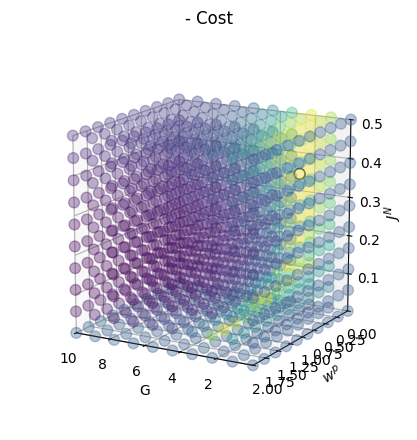

In [9]:
import matplotlib.pyplot as plt

grid.plot_space('-cost', opt=True, config=dict(size=60, alpha=0.35, azim=120))
plt.tight_layout()

In this model, cost function is calculated as `- (gof - fic_penalty)`. We can next visualize these components of cost function, which are included in `+gof` and `-fic_penalty` columns of `cmaes.history`.

<div class="alert alert-info">
<p>
The signs in front of each cost component indicate the optimization direction: a `+` sign means the quantity is <b>maximized</b>, while a `-` sign means it is <b>minimized</b>.  
For example: `+gof` (maximize goodness-of-fit), `+fc_corr` (maximize FC correlation), `-fcd_ks` (minimize FCD KS distance), `-fic_penalty` (minimize FIC penalty).
</p>
</div>

<div class="alert alert-info">
<p>
Note: FIC penalty in rWW model can be disabled by setting `fic_penalty_scale = 0` when creating the `BNMProblem` object. 
</p>
</div>

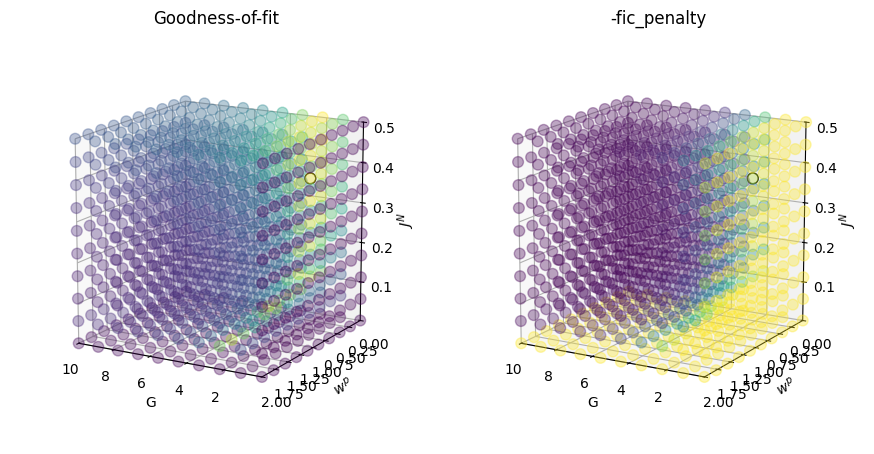

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4.5), subplot_kw={'projection': '3d'})
for i, var in enumerate(['+gof', '-fic_penalty']):
    grid.plot_space(var, opt=True, config=dict(size=60, alpha=0.35, azim=120), ax=axes[i])
fig.tight_layout()

The goodness-of-fit (`+gof`) itself is composed of two components: `+gof = (+fc_corr) + (-fcd_ks)`. Next, we will visualize these components:

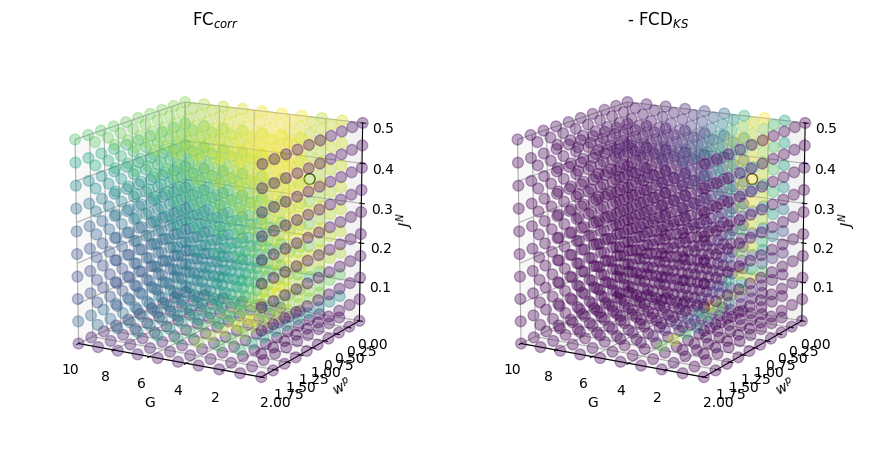

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4.5), subplot_kw={'projection': '3d'})
for i, var in enumerate(['+fc_corr', '-fcd_ks']):
    grid.plot_space(var, opt=True, config=dict(size=60, alpha=0.35, azim=120), ax=axes[i])
fig.tight_layout()

The plots above show that while many parameter combinations result in high FC correlation and low FIC penalty (i.e., higher values of `+fc_corr` and `-fic_penalty`), only a narrow band of parameter values leads to simulations with realistic dynamics, as reflected by higher values of `-fcd_ks`. This pattern is in turn reflected in the grids of `+gof` and negative `cost`.

In addition to the evaluation metrics plotted above, we can also visualize how average state variables vary across the parameter space.  This can provide further insights into how the model’s behavior changes as a function of different parameters.

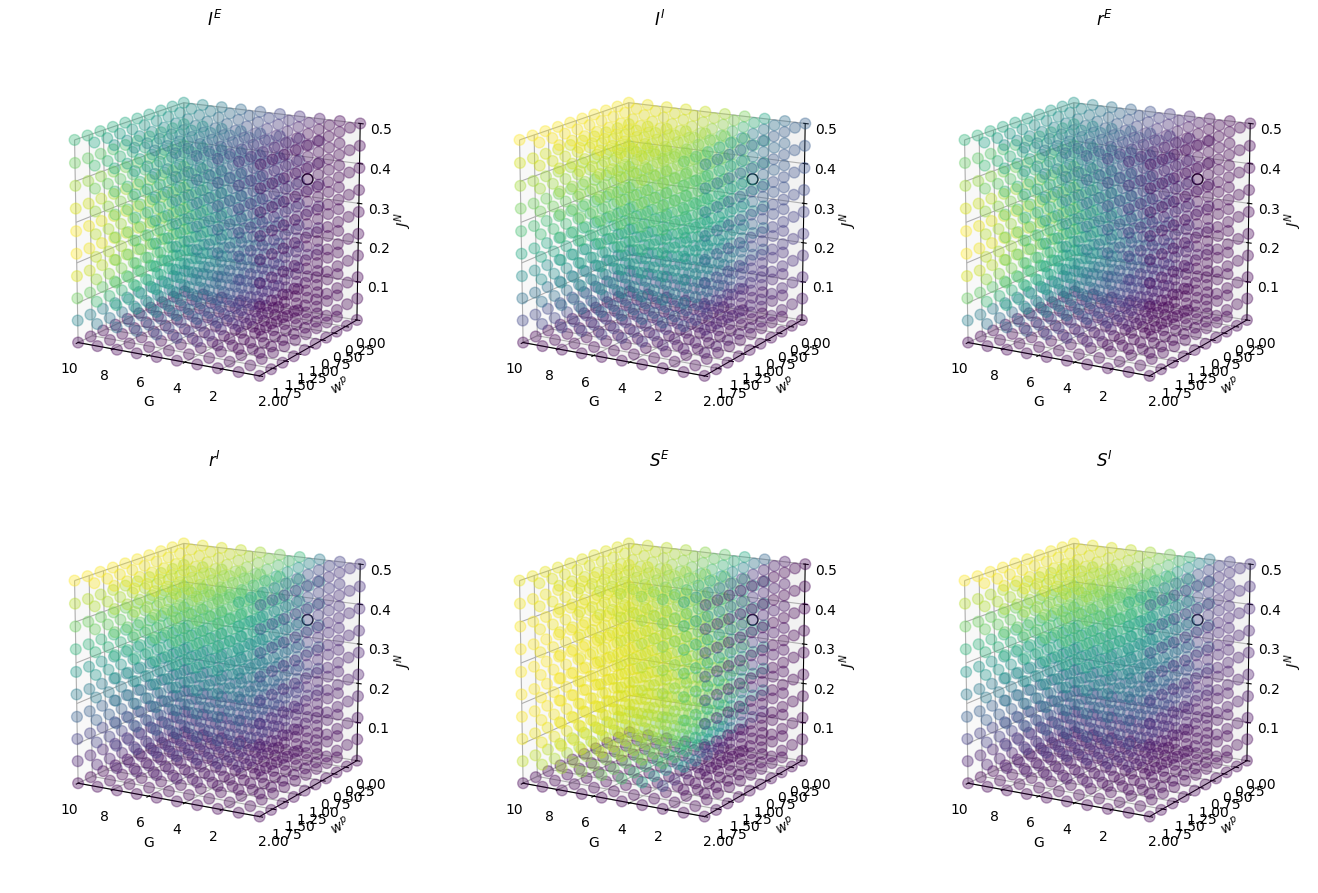

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(13.5, 9), subplot_kw={'projection': '3d'})
axes = axes.flatten()
for i, var in enumerate(grid.problem.sim_group.sim_states.keys()):
    grid.plot_space(var, opt=True, config=dict(size=60, alpha=0.35, azim=120), ax=axes[i])
fig.tight_layout()

## Visualization of the optimal simulation

Lastly, we will visualize the simulated FC and FCD of the optimal simulation and compare them to the empirical data.

We can then plot the empirical group-averaged FC next to the simulated FC:

Text(0.5, 1.0, 'Simulated FC')

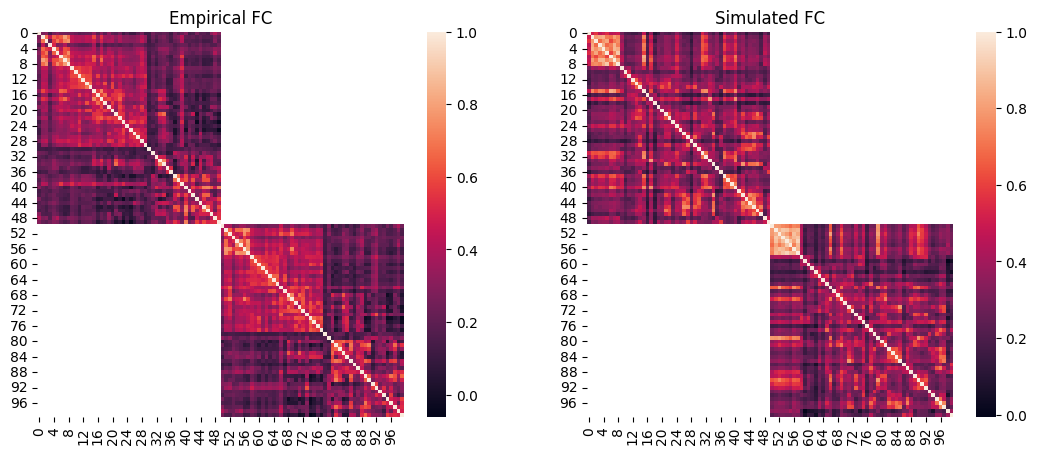

In [13]:
import seaborn as sns

# load the squared form of the empirical FC
emp_fc = datasets.load_fc('schaefer-100', 'group-train706', exc_interhemispheric=True, return_tril=False)


# determine the index of optimal simulation
# which is the name of the optimum pandas Series
opt_idx = grid.opt.name

# load squared form of optimal simulated FC
sim_fc = grid.problem.sim_group.get_sim_fc(opt_idx)

# plot it next to the empirical FC
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(emp_fc, ax=axes[0])
axes[0].set_title("Empirical FC")
sns.heatmap(sim_fc, ax=axes[1])
axes[1].set_title("Simulated FC")

FC correlation = 0.30322564112211214


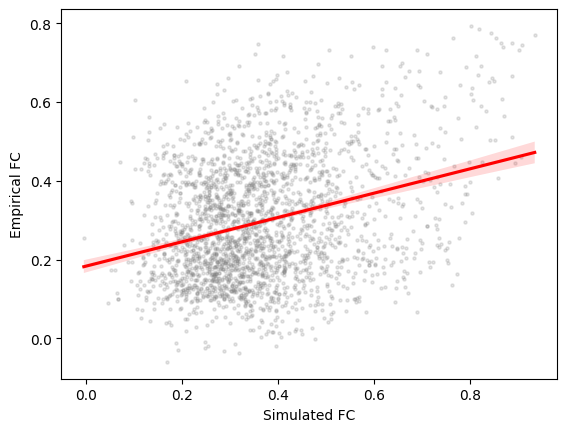

In [14]:
import scipy.stats

# regression plot
fig, ax = plt.subplots()
sns.regplot(
    x=grid.problem.sim_group.sim_fc_trils[opt_idx],
    y=emp_fc_tril,
    scatter_kws=dict(s=5, alpha=0.2, color="grey"),
    line_kws=dict(color="red"),
)
ax.set_xlabel("Simulated FC")
ax.set_ylabel("Empirical FC")

# calculate Pearson correlation
print(f"FC correlation = {scipy.stats.pearsonr(grid.problem.sim_group.sim_fc_trils[opt_idx], emp_fc_tril).statistic}")

In addition to static FC, we can also plot the simulated FCD matrix distribution next to the empirical FCD (pooled across the group), and calculate their Kolmogorov-Smirnov distance:

FCD KS distance = 0.14457225238790572


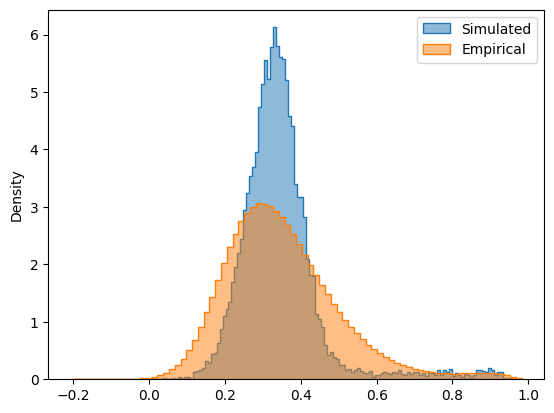

In [15]:
# plot the distributions next to each other
sns.histplot(grid.problem.sim_group.sim_fcd_trils[opt_idx], element='step', alpha=0.5, label='Simulated', stat='density')
ax = sns.histplot(emp_fcd_tril, element='step', alpha=0.5, label='Empirical', stat='density')
ax.legend()

# calculate KS distance
print(f"FCD KS distance = {scipy.stats.ks_2samp(emp_fcd_tril, grid.problem.sim_group.sim_fcd_trils[opt_idx]).statistic}")

The fit of simulated FC and FCD to the empirical data is quantified as `+fc_corr` and `-fcd_ks`, which are combined to define `+gof`. These evaluation metrics as well as the optimal parameters are stored in `grid.opt`:

In [16]:
grid.opt

G               1.112000
w_p             0.666667
J_N             0.389111
+fc_corr        0.303226
-fcd_ks        -0.144572
+gof            0.158653
-fic_penalty   -0.057502
cost           -0.101152
Name: 137, dtype: float64

We observe that, after tuning model parameters using grid search, the simulated FC and FCD more closely resemble the empirical FC and FCD compared to the simulation performed with arbitrary parameters in the previous tutorial.

However, as we will explore in the next tutorials, there is still room for improvement, in terms of both the optimization approach and the model.